In [1]:
import pyedflib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.fftpack import rfft, irfft, fftfreq
import os
 
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

import itertools

%matplotlib inline

In [2]:
HOME = "/home/jonnatas/git/mlModels/sistema/modelo/DB_REPO/edf/"
def dadosPK(tipo):
    dir_ct = HOME+tipo+"/"
    return os.listdir(HOME+tipo+"/")

In [3]:
def carregarDataFrame(tipo, caminho):
    caminho = HOME+tipo+"/"+caminho
    
    edf = pyedflib.EdfReader(caminho)
    n = edf.signals_in_file
    sigbufs = np.zeros((n, edf.getNSamples()[0]))
    for i in np.arange(n):
         sigbufs[i, :] = edf.readSignal(i)
    edf._close()
    del edf

    return pd.DataFrame(data=sigbufs.T, columns=['ch1', 'ch2', 'ch3', 'ch4'])

In [4]:
def fft(df, canal):
    amostras = int(df[canal][2000:11000].shape[0]*500/2000)
    sinal = np.abs(np.fft.fft(df[canal][2000:11000]))[:amostras]
    freq = np.linspace(0,500,amostras)
    
    return (sinal,freq)

def plotarFFT(a, b, titulo):
    plt.title(titulo)
    plt.plot(b,a)
    plt.xlim([0,500])
    plt.ylim([0,5000])
    plt.show

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Matriz de confusão sobre diabetes',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(12,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Esperado')
    plt.xlabel('Obtido')

In [6]:
def frequecia(df, canal):
    sinalFFT = [fft(data, canal)[0] for data in df]

    return sinalFFT

In [7]:
parkinson = dadosPK('parkinson')
controle = dadosPK('controle')
df_ct = [ carregarDataFrame('controle', nome) for nome in controle]
df_pk = [ carregarDataFrame('parkinson', nome) for nome in parkinson]

# Outros canais

In [8]:
sinaisCT = [frequecia(df_ct, 'ch'+str(i+1)) for i in range(4)]
sinaisPK = [frequecia(df_pk, 'ch'+str(i+1)) for i in range(4)]

rotulosCT = [0 for _ in range(len(sinaisPK[0]))]
rotulosPK = [1 for _ in range(len(sinaisPK[0]))]

trainData = [sinaisCT[i]+sinaisPK[i] for i in range(len(sinaisCT))]
rotulos = rotulosCT + rotulosPK

nomes = ['parkinson', 'controle']

In [9]:
# X_train, X_test, y_train, y_teste = train_test_split(trainData, rotulos, test_size=0.3)
trainCH1, trainCH2, trainCH3, trainCH4 = [train_test_split(train, rotulos, test_size=0.3, random_state=32) for train in trainData]

In [10]:
param_grid = [
  {'C': [0.1, 1, 10], 'gamma': [0.001, 0.0001], 'kernel': ['sigmoid']},
  {'C': [0.1, 1, 10], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
  {'C': [0.1, 1, 10], 'gamma': [0.001, 0.0001], 'kernel':['poly'], 'degree':[3,4]}
 ]
gridTrain = [GridSearchCV(SVC(), param_grid, refit=True) for _ in range(4)]
gridTrain[0].fit(trainCH1[0], trainCH1[2])
gridTrain[1].fit(trainCH2[0], trainCH2[2])
gridTrain[2].fit(trainCH3[0], trainCH3[2])
gridTrain[3].fit(trainCH4[0], trainCH4[2])

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.1, 1, 10], 'gamma': [0.001, 0.0001], 'kernel': ['sigmoid']}, {'C': [0.1, 1, 10], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}, {'C': [0.1, 1, 10], 'gamma': [0.001, 0.0001], 'kernel': ['poly'], 'degree': [3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [11]:
for i in gridTrain:
    print(i.best_params_)
    print(i.best_score_)
    
y_pred = [grid.predict(trainCH1[1]) for grid in gridTrain]

{'C': 0.1, 'degree': 4, 'gamma': 0.001, 'kernel': 'poly'}
0.6379310344827587
{'C': 0.1, 'degree': 3, 'gamma': 0.001, 'kernel': 'poly'}
0.7586206896551724
{'C': 0.1, 'degree': 3, 'gamma': 0.001, 'kernel': 'poly'}
0.7241379310344828
{'C': 0.1, 'degree': 3, 'gamma': 0.001, 'kernel': 'poly'}
0.6551724137931034


In [12]:
def plotarMatriz(y_teste, y_pred, canal):
    # Matriz de confusão
    print("Canal: "+canal)
    cnf_matrix = confusion_matrix(y_teste, y_pred )
    np.set_printoptions(precision=2)
    # Sem normalização
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=nomes, title='Matriz de confusão: '+canal)
    print(classification_report(y_pred, y_teste, target_names=nomes))

Canal: ch1
             precision    recall  f1-score   support

  parkinson       0.86      0.75      0.80        16
   controle       0.67      0.80      0.73        10

avg / total       0.78      0.77      0.77        26



<Figure size 432x288 with 0 Axes>

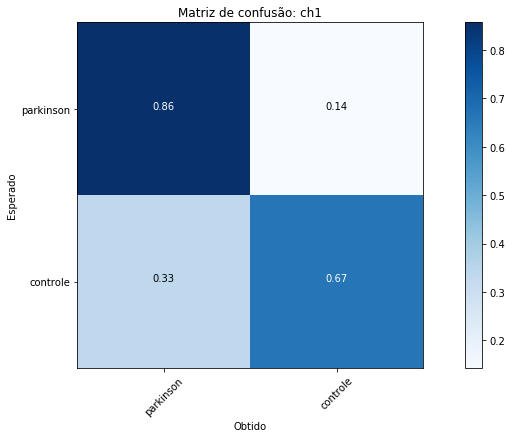

In [13]:
plotarMatriz(trainCH1[3], y_pred[0], 'ch1')

Canal: ch2
             precision    recall  f1-score   support

  parkinson       0.64      0.60      0.62        15
   controle       0.50      0.55      0.52        11

avg / total       0.58      0.58      0.58        26



<Figure size 432x288 with 0 Axes>

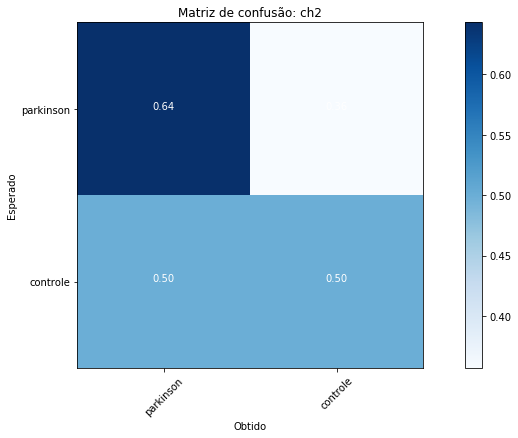

In [14]:
plotarMatriz(trainCH2[3], y_pred[1], 'ch2')

Canal: ch3
             precision    recall  f1-score   support

  parkinson       0.71      0.71      0.71        14
   controle       0.67      0.67      0.67        12

avg / total       0.69      0.69      0.69        26



<Figure size 432x288 with 0 Axes>

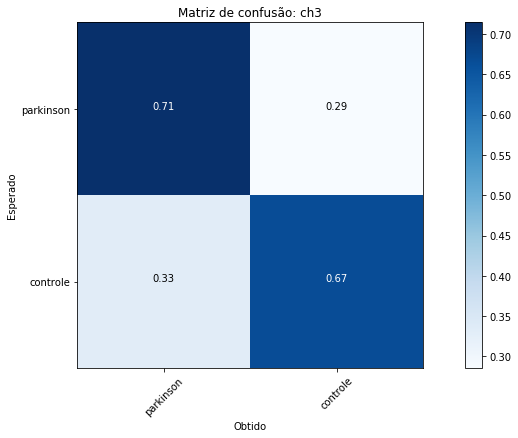

In [15]:
plotarMatriz(trainCH3[3], y_pred[2], 'ch3')

Canal: ch4
             precision    recall  f1-score   support

  parkinson       0.71      0.53      0.61        19
   controle       0.25      0.43      0.32         7

avg / total       0.59      0.50      0.53        26



<Figure size 432x288 with 0 Axes>

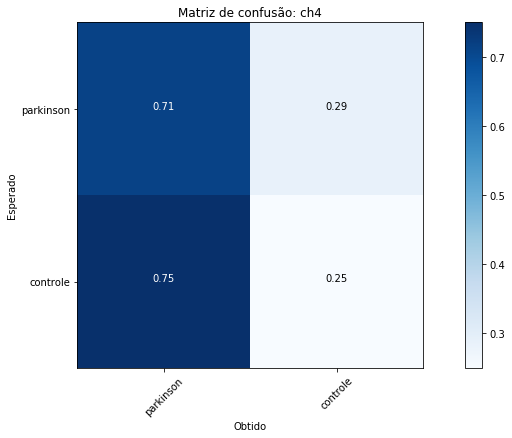

In [16]:
plotarMatriz(trainCH4[3], y_pred[3], 'ch4')